In [1]:
import torch

In [2]:
torch.__version__

'1.10.2'

In [3]:
import pandas as pd
import numpy as np
import os
import tqdm

In [47]:
def create_datasets(batch_size):
    valid_size = 0.2

    # torch.FloatTensor로 변환
    train_csv = pd.read_csv('./data/train.csv')
    test_csv = pd.read_csv('./data/test.csv')

    train_data = torch.tensor(train_csv.to_numpy()).float()
    test_data = torch.tensor(test_csv.to_numpy()).float()

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = (np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    vaild_data = train_data[valid_idx]
    train_data = train_data[train_idx]
    # train_sampler = SubsetRandomSampler(train_idx)
    # valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                            #    sampler=train_sampler,
                                               num_workers=0)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                            #    sampler=valid_sampler,
                                               num_workers=0)

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)

    return train_loader, test_loader, valid_loader


In [38]:
print(len(x_train))

2335


In [5]:
data = df.to_numpy()
np.random.shuffle(data)

In [6]:
x_train = data[:, 1:33]
y_train = data[:, 33]

In [7]:
print(x_train.shape)
print(y_train.shape)

(2335, 32)
(2335,)


In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
torch.cuda.get_device_name(0)

'GeForce MX250'

In [10]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            # nn.Dropout(0.3),

            nn.Linear(8, 4)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

In [11]:
model = net().to(device)
print(model)

net(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [12]:
from torchsummary import summary

summary(model, (32, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             528
       BatchNorm1d-2                   [-1, 16]              32
              ReLU-3                   [-1, 16]               0
            Linear-4                    [-1, 8]             136
       BatchNorm1d-5                    [-1, 8]              16
              ReLU-6                    [-1, 8]               0
            Linear-7                    [-1, 4]              36
Total params: 748
Trainable params: 748
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [44]:

print(model(torch.tensor(x_train).to(device).float()))

tensor([[ 0.0041, -0.2144,  0.0827,  0.0462],
        [-0.0226, -0.2334,  0.2624, -0.2914],
        [ 0.0404,  0.0350,  0.3017, -0.1628],
        ...,
        [ 0.6057,  0.2771,  0.0832, -0.3616],
        [-1.0311,  0.4972,  0.7276, -0.7903],
        [-0.1930,  0.3126,  0.2188,  0.6403]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [13]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [52]:
def train_model(model, batch_size, patience, n_epochs):

    # 모델이 학습되는 동안 trainning loss를 track
    train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    valid_losses = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []

    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, datas in enumerate(train_loader, 1):
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()    
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # backward pass: 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for datas in valid_loader:
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print 학습/검증 statistics
        # epoch당 평균 loss 계산
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))


        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

   # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [53]:
learning_rate = 0.001
batch_size = 64
epochs = 100
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience = 20
n_epochs = 100
train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[  1/100] train_loss: 1.42869 valid_loss: 1.38557
Validation loss decreased (inf --> 1.385574).  Saving model ...
[  2/100] train_loss: 1.37029 valid_loss: 1.34194
Validation loss decreased (1.385574 --> 1.341936).  Saving model ...
[  3/100] train_loss: 1.32794 valid_loss: 1.30762
Validation loss decreased (1.341936 --> 1.307621).  Saving model ...
[  4/100] train_loss: 1.29847 valid_loss: 1.27381
Validation loss decreased (1.307621 --> 1.273809).  Saving model ...
[  5/100] train_loss: 1.26553 valid_loss: 1.23682
Validation loss decreased (1.273809 --> 1.236825).  Saving model ...
[  6/100] train_loss: 1.22549 valid_loss: 1.19562
Validation loss decreased (1.236825 --> 1.195618).  Saving model ...
[  7/100] train_loss: 1.19128 valid_loss: 1.15650
Validation loss decreased (1.195618 --> 1.156498).  Saving model ...
[  8/100] train_loss: 1.15122 valid_loss: 1.11959
Validation loss decreased (1.156498 --> 1.119593).  Saving model ...
[  9/100] train_loss: 1.10743 valid_loss: 1.07099
Val

In [57]:
from matplotlib import pyplot as plt

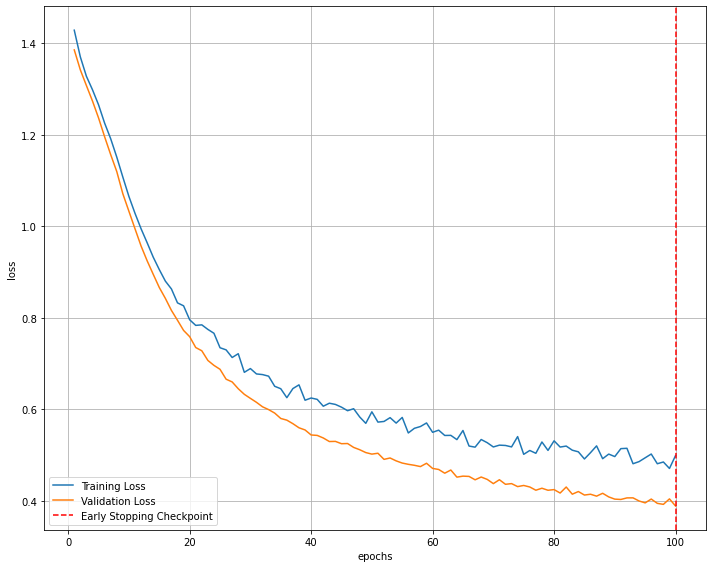

In [59]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [80]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval() # prep model for evaluation
for datas in valid_loader:
    # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
    data = datas[:, 1:33].to(device)
    target = datas[:, 33].to(device).to(torch.int64)

    output = model(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # 출력된 확률을 예측된 클래스로 변환
    _, pred = torch.max(output, 1)
    # 예측과 실제 라벨과 비교
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 각 object class에 대해 test accuracy 계산
    for i in range(batch_size):
        label = target[i].to('cpu').numpy()
        print(label)
        class_correct[label] += correct[i].item()
        class_total[label] +=1

# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

3
3
0
0
3
1
2
2
3
0
2
2
1
3
2
2
2
2
1
2
0
2
3
3
3
2
3
2
1
3
2
3
3
1
2
3
3
1
2
0
1
3
3
1
3
1
0
2
3
0
3
2
0
2
1
2
2
2
3
3
0
1
3
1
2
1
0
3
2
2
0
1
3
1
2
0
0
3
1
3
3
1
2
1
2
2
0
0
2
0
1
3
0
1
2
3
3
0
1
0
3
2
3
1
0
3
0
1
2
2
0
3
0
0
1
2
3
3
3
1
1
2
0
3
1
1
3
0
3
1
0
2
0
2
1
2
3
2
2
2
1
1
1
3
0
2
2
3
3
3
0
1
3
1
1
1
1
0
0
3
1
1
1
0
1
1
3
3
2
1
0
0
3
0
2
1
1
1
0
0
3
3
0
2
0
0
0
3
0
0
0
2
2
2
2
2
0
2
0
0
3
2
2
2
2
3
0
0
2
2
1
3
3
3
0
3
3
0
3
0
3
1
1
1
3
0
2
3
3
3
2
3
1
2
3
3
1
3
3
2
2
2
1
1
2
3
2
3
2
2
2
0
3
1
0
0
2
1
0
0
0
3
1
3
1
1
2
1
0
1
2
0
3
2
2
2
2
3
2
0
0
1
2
0
2
1
2
3
1
2
1
1
1
3
3
0
3
0
2
2
0
0
1
1
0
1
3
1
0
3
0
1
1
3
3
2
0
1
3
3
1
2
2
2
2
0
1
1
1
0
0
0
0
3
2
0
3
1
1
1
2
0
0
0
0
0
1
2
2
3
1
1
3
2
3
3
2
0
2
3
1
1
1
1
3
1
0
3
1
3
0
0
0
1
1
2
2
3
1
1
3
2
3
1
1
2
2
1
1
3
0
0
3
3
0
1
0
3
3
1
0
0
0
2
0
3
3
1
1
2
0
2
0
1
3
3
1
2
0
0
3
0
3
3
0
3
0
3
1
1
1
0
1
1
0
0
3
0
2
0
0
3
0
3
3
3
1
3
1
2
3
0
2
2
2
2
3
3
3
2
2
0
2
1
1
1
3
0
2
3
3
0
3
2
0
2
2
3
1
0
3
2
3
0
3
3
3
1
1
0
0
2
3
0
1
1
0
1
1
2


IndexError: index 41 is out of bounds for dimension 0 with size 41